In [53]:
import numpy as np
from astropy.table import Table

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
from lsst.afw.math import Warper

import lsst.afw.geom as afwGeom



import lsst.geom as geom
import lsst.afw.image as afwImage

In [54]:
# Setup data id
tract, patch, filt = 4639, '0,0', 'r'
visit, detector = 181868, 57
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
deepCoadd_id = {'tract': tract, 'patch': patch, 'filter': filt}

In [55]:
calexp_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1'
calexp_butler = Butler(calexp_repo)
calexp_exposure = calexp_butler.get('calexp',  calexp_id)

In [56]:
template_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/coadd-dr1b-v1-grizy'
template_butler = Butler(template_repo)



In [57]:
template_exposure = template_butler.get('deepCoadd',  deepCoadd_id)

In [58]:
def inject_stars(exposure, photoCalib, x, y, magVar, poisson=False, seed=None):
    exposure.mask.addMaskPlane("FAKE")
    bitmask = exposure.mask.getPlaneBitMask("FAKE")
    xy = geom.Point2D(x, y)
    psf = exposure.getPsf()
    starIm = psf.computeImage(xy)
    calibFluxRadius = 12
    correctedFlux = psf.computeApertureFlux(calibFluxRadius, xy)
    starIm /= correctedFlux
    flux = photoCalib.magnitudeToInstFlux(magVar, xy)
    starIm *= flux
    star_shape = starIm.array.shape
    star_array = starIm.getArray()
    star_array[star_array < 1e-19] = 0.

    if poisson:
        # The array of starIm will be changed inplace, we make a copy here to calculate the variance plane.
        star_array_copy = starIm.array.copy()
        star_array_copy = np.float32(star_array_copy)
        
        for i in range(star_shape[0]):
            for j in range(star_shape[1]):
                np.random.seed(seed)
                star_array[i][j] = np.random.poisson(star_array[i][j] * 0.7) / 0.7

    fakeImage = starIm.convertF()
    imageBBox = exposure.getBBox()
    imageMI = exposure.maskedImage

    interpFakeImage = fakeImage
    interpFakeImBBox = fakeImage.getBBox()
    interpFakeImBBox.clip(imageBBox)
    imageMIView = imageMI.Factory(imageMI, interpFakeImBBox)

    if interpFakeImBBox.getArea() > 0:
        clippedFakeImage = interpFakeImage.Factory(interpFakeImage, interpFakeImBBox)
        clippedFakeImageMI = afwImage.MaskedImageF(clippedFakeImage)
        clippedFakeImageMI.mask.set(bitmask)
        if poisson:
            clippedFakeImageMI.variance.array = star_array_copy / 0.7
        imageMIView += clippedFakeImageMI

In [59]:
def save_fakes(calexp_repo, calexp_id, magVar, src_table, poisson=False):
    
    calexp_butler = Butler(calexp_repo)
    calexp_photoCalib = calexp_butler.get('calexp_photoCalib',  calexp_id)
    calexp_exposure = calexp_butler.get('calexp', dataId=calexp_id)
    for row in src_table:
        x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
        seed = int('{}{}{}'.format(18, int(magVar * 10), int(x) + int(y)))
        inject_stars(calexp_exposure, calexp_photoCalib, x, y, magVar, poisson=False, seed=seed)
    calexp_butler.put(calexp_exposure, 'calexp', dataId=calexp_id)

In [60]:
def filter_src(src_table):
    # This function filters out sources with flags.
    flag_list = ['base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
                'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
                'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
                'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_suspectCenter']

    row_num = []
    for num, src in enumerate(src_table):
        flag_count = 0
        for flag in flag_list:
            # Here is data type is np.bool_, not python's built-in bool
            if src[flag] is np.bool_(True):
                flag_count += 1
        if flag_count == 0:
            row_num.append(num)
    good_table = src_table[row_num]
    return good_table



def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_SdssCentroid_x']
            src_y = src['base_SdssCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                count += 1
                break
        if count == 0:
            missed_list.append(i)
    return detected_list, missed_list



In [61]:
def make_cutout(exposure, x, y, cutout_size=60):
    # Make a cutout exposure at (x, y).
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image


def display_cutout(cutout_image, x, y, scale=None, frame=None, title=None, show_mask_name=False, save_name=None):
    # Display the cutout image.
    
    # xy = geom.Point2I(x, y)
    # Call to deprecated function (or staticmethod) Point2I.
    # (Replaced by lsst.geom.PointI (will be removed before the release of v20.0))
    xy = geom.PointI(x, y)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
        
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    display.show_colorbar()
    plt.title(title)
    
    if show_mask_name:
        print(title)
        mask = cutout_image.getMask()
        for maskName, maskBit in mask.getMaskPlaneDict().items():
            print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)), end=' ')
        print('\n')
        
    if save_name:
        plt.savefig(save_name, dpi=500)
    
def display_xy(exposure, x, y, cutout_size=60, scale=None, frame=None, title=None,
               show_mask_name=False, save_name=None):
    cutout = make_cutout(exposure, x, y, cutout_size=cutout_size)
    display_cutout(cutout, x, y, scale=scale, frame=frame, title=title,
                    show_mask_name=show_mask_name, save_name=save_name)
    
def warp_to_exposure(exposure, warp_to_exposure):
    warper = Warper(warpingKernelName='lanczos4')
    exposure_warped = warper.warpExposure(warp_to_exposure.getWcs(), exposure,
                                          destBBox=warp_to_exposure.getBBox())
    return exposure_warped

def get_mask_name(exposure):
    mask = exposure.getMask()
    for maskName, maskBit in mask.getMaskPlaneDict().items():
        print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))
        
def display_exposures(x, y, diff_butler, calexp_butler, deepCoadd_butler,
                      calexp_id, deepCoadd_id, cutout_size=60, scale=None,
                      show_mask_name=False):
    diff_exposure = diff_butler.get('deepDiff_differenceExp', calexp_id)
    calexp_exposure = calexp_butler.get('calexp', calexp_id)
    deepCoadd_exposure = deepCoadd_butler.get('deepCoadd',  deepCoadd_id)
    
    deepCoadd_warped = warp_to_exposure(deepCoadd_exposure, calexp_exposure)
    
    # calexp_xy = geom.Point2I(x, y)
    # Call to deprecated function (or staticmethod) Point2I.
    # (Replaced by lsst.geom.PointI (will be removed before the release of v20.0))
    calexp_xy = geom.PointI(x, y)
    calexp_radec = geom.SpherePoint(calexp_exposure.getWcs().pixelToSky(x, y))
    
    deepCoadd_xy = afwGeom.PointI(deepCoadd_warped.getWcs().skyToPixel(calexp_radec))
    
    deepCoadd_x, deepCoadd_y = deepCoadd_xy.getX(), deepCoadd_xy.getY()
    
    display_xy(diff_exposure, x, y, cutout_size=60, scale=None, frame=10001, title='diff',
                show_mask_name=show_mask_name, save_name=None)
    display_xy(calexp_exposure, x, y, cutout_size=60, scale=None, frame=10002, title='calexp',
               show_mask_name=show_mask_name, save_name=None)
    display_xy(deepCoadd_warped, deepCoadd_x, deepCoadd_y, cutout_size=60,
               scale=None, frame=10003, title='deepCoadd',
               show_mask_name=show_mask_name, save_name=None)
        
    

In [62]:
mag_list = ['160','165','170','175','180','185','190','195','200','205','210','215','220','225','230','235','240']

In [63]:
check18_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check18_offset_25.txt',
                               format='ascii')
check20_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check20_offset_25.txt',
                               format='ascii')
check21_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check21_offset_25.txt',
                               format='ascii')
check22_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check22_offset_25.txt',
                               format='ascii')
check23_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check23_offset_25.txt',
                               format='ascii')
check24_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check24_offset_25.txt',
                               format='ascii')

## Injection

In [64]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################

In [65]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_18_offset/fake_18_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check18_offset, poisson=False)

In [66]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_20_offset/fake_20_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check20_offset, poisson=False)

In [67]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_21_offset/fake_21_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check21_offset, poisson=False)

In [68]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_22_offset/fake_22_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check22_offset, poisson=False)

In [69]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_23_offset/fake_23_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check23_offset, poisson=False)

In [70]:
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_24_offset/fake_24_{}_offset'.format(mag_str)
    save_fakes(repo, calexp_id, mag, check24_offset, poisson=False)

In [71]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################

In [42]:
flag_list = ['base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
            'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
            'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
            'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_suspectCenter']

## Analysis

In [32]:
def make_cutout(exposure, ra, dec, cutout_size=60):
    # Make a cutout exposure at (x, y).
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    # radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def display_cutout_radec(cutout_image, ra, dec, scale=None, frame=None, title=None, save_name=None):
    # Display the cutout image.
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
        
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    display.show_colorbar()
    plt.title(title)
    if save_name:
        plt.savefig(save_name, dpi=500)
        
def display_radec(exposure, x, y, cutout_size=60, scale=None, frame=None, title=None, save_name=None):
    cutout = make_cutout(exposure, x, y, cutout_size=cutout_size)
    display_cutout_radec(cutout, x, y, scale=scale, frame=frame, title=title, save_name=save_name)

## compare to the Poisson model without editing variance plane

In [42]:
efficiency_18 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_18_offset/al_18_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check18_offset, half_side=4, filt_flag=False)
    efficiency_18[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [43]:
efficiency_20 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_20_offset/al_20_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check20_offset, half_side=4, filt_flag=False)
    efficiency_20[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [44]:
efficiency_21 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_21_offset/al_21_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check21_offset, half_side=4, filt_flag=False)
    efficiency_21[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [45]:
efficiency_22 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_22_offset/al_22_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=4, filt_flag=False)
    efficiency_22[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [46]:
efficiency_23 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_23_offset/al_23_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=4, filt_flag=False)
    efficiency_23[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [47]:
efficiency_24 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_24_offset/al_24_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=4, filt_flag=False)
    efficiency_24[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [48]:
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_sdss', efficiency_18)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_sdss', efficiency_20)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_sdss', efficiency_21)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_sdss', efficiency_22)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_sdss', efficiency_23)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_sdss', efficiency_24)

## with variance

In [18]:
efficiency_18 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_18_offset/al_18_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check18_offset, half_side=4, filt_flag=False)
    efficiency_18[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [19]:
efficiency_20 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_20_offset/al_20_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check20_offset, half_side=4, filt_flag=False)
    efficiency_20[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [20]:
efficiency_21 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_21_offset/al_21_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check21_offset, half_side=4, filt_flag=False)
    efficiency_21[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [21]:
efficiency_22 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_22_offset/al_22_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=4, filt_flag=False)
    efficiency_22[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [22]:
efficiency_23 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_23_offset/al_23_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=4, filt_flag=False)
    efficiency_23[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [23]:
efficiency_24 = np.zeros(17)
for i, mag in enumerate(np.arange(16, 24.5, 0.5)):
    mag_str = mag_list[i]
    repo = '/global/u1/s/shl159/GitHub/fake_large/fake_24_offset/al_24_{}_offset'.format(mag_str)
    diff_detected, diff_missed = check_detecion(repo, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=4, filt_flag=False)
    efficiency_24[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

In [24]:
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_noflag', efficiency_18)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_noflag', efficiency_20)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_noflag', efficiency_21)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_noflag', efficiency_22)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_noflag', efficiency_23)
np.save('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_noflag', efficiency_24)

## Comparison Plots

In [26]:
efficiency_18_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_novar.npy')
efficiency_20_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_novar.npy')
efficiency_21_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_novar.npy')
efficiency_22_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_novar.npy')
efficiency_23_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_novar.npy')
efficiency_24_novar = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_novar.npy')

In [27]:
efficiency_18_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_noflag.npy')
efficiency_20_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_noflag.npy')
efficiency_21_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_noflag.npy')
efficiency_22_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_noflag.npy')
efficiency_23_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_noflag.npy')
efficiency_24_noflag = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_noflag.npy')

In [49]:
efficiency_18_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_perfect.npy')
efficiency_20_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_perfect.npy')
efficiency_21_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_perfect.npy')
efficiency_22_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_perfect.npy')
efficiency_23_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_perfect.npy')
efficiency_24_perfect = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_perfect.npy')

In [50]:
efficiency_18_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_18_offset_sdss.npy')
efficiency_20_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_20_offset_sdss.npy')
efficiency_21_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_21_offset_sdss.npy')
efficiency_22_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_22_offset_sdss.npy')
efficiency_23_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_23_offset_sdss.npy')
efficiency_24_sdss = np.load('/global/u1/s/shl159/GitHub/fake_large/efficiency_24_offset_sdss.npy')

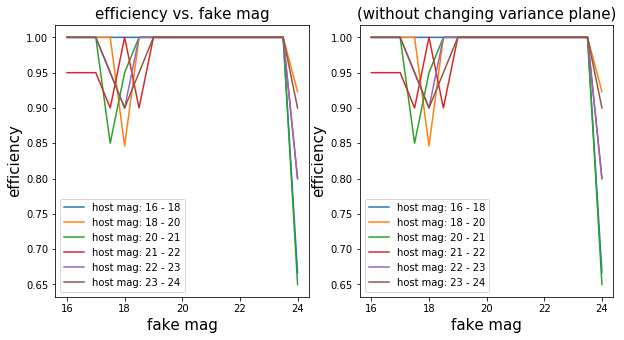

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mag_range = np.arange(16, 24.5, 0.5)
axs[0].plot(mag_range, efficiency_18_noflag, label='host mag: 16 - 18')
axs[0].plot(mag_range, efficiency_20_noflag, label='host mag: 18 - 20')
axs[0].plot(mag_range, efficiency_21_noflag, label='host mag: 20 - 21')
axs[0].plot(mag_range, efficiency_22_noflag, label='host mag: 21 - 22')
axs[0].plot(mag_range, efficiency_23_noflag, label='host mag: 22 - 23')
axs[0].plot(mag_range, efficiency_24_noflag, label='host mag: 23 - 24')

axs[0].set_xlabel('fake mag', size=15)
axs[0].set_ylabel('efficiency', size=15)
axs[0].set_title('efficiency vs. fake mag', size=15)
axs[0].legend()

axs[1].plot(mag_range, efficiency_18_novar, label='host mag: 16 - 18')
axs[1].plot(mag_range, efficiency_20_novar, label='host mag: 18 - 20')
axs[1].plot(mag_range, efficiency_21_novar, label='host mag: 20 - 21')
axs[1].plot(mag_range, efficiency_22_novar, label='host mag: 21 - 22')
axs[1].plot(mag_range, efficiency_23_novar, label='host mag: 22 - 23')
axs[1].plot(mag_range, efficiency_24_novar, label='host mag: 23 - 24')


axs[1].set_xlabel('fake mag', size=15)
axs[1].set_ylabel('efficiency', size=15)
axs[1].set_title('(without changing variance plane)', size=15)
axs[1].legend()

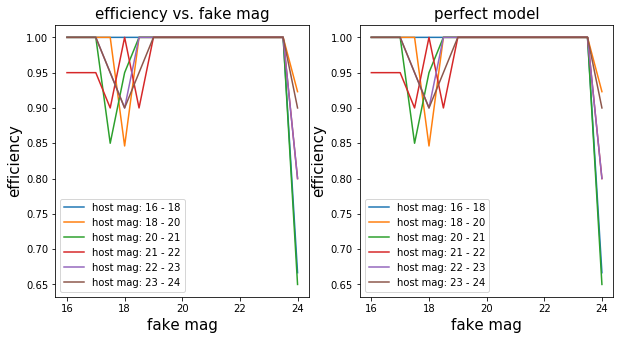

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mag_range = np.arange(16, 24.5, 0.5)
axs[0].plot(mag_range, efficiency_18_sdss, label='host mag: 16 - 18')
axs[0].plot(mag_range, efficiency_20_sdss, label='host mag: 18 - 20')
axs[0].plot(mag_range, efficiency_21_sdss, label='host mag: 20 - 21')
axs[0].plot(mag_range, efficiency_22_sdss, label='host mag: 21 - 22')
axs[0].plot(mag_range, efficiency_23_sdss, label='host mag: 22 - 23')
axs[0].plot(mag_range, efficiency_24_sdss, label='host mag: 23 - 24')

axs[0].set_xlabel('fake mag', size=15)
axs[0].set_ylabel('efficiency', size=15)
axs[0].set_title('efficiency vs. fake mag', size=15)
axs[0].legend()

axs[1].plot(mag_range, efficiency_18_perfect, label='host mag: 16 - 18')
axs[1].plot(mag_range, efficiency_20_perfect, label='host mag: 18 - 20')
axs[1].plot(mag_range, efficiency_21_perfect, label='host mag: 20 - 21')
axs[1].plot(mag_range, efficiency_22_perfect, label='host mag: 21 - 22')
axs[1].plot(mag_range, efficiency_23_perfect, label='host mag: 22 - 23')
axs[1].plot(mag_range, efficiency_24_perfect, label='host mag: 23 - 24')


axs[1].set_xlabel('fake mag', size=15)
axs[1].set_ylabel('efficiency', size=15)
axs[1].set_title('perfect model', size=15)
axs[1].legend()

## check missing objects without applying flag cut

In [57]:
def make_cutout(exposure, x, y, cutout_size=60):
    # Make a cutout exposure at (x, y).
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def display_diff(diff_exposure, x, y, cutout_size=60, dia_list=None, scale=None, frame=None, title=None):
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(diff_exposure.getWcs().pixelToSky(x, y))
    cutout_image = diff_exposure.getCutout(radec, cutout_extent)
    
    xy = geom.PointI(x, y)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    
    for coord in dia_list:
        coord_x, coord_y = coord
        display.dot('o', coord_x, coord_y, ctype='green')
        
    display.show_colorbar()
    plt.title(title)
    


In [359]:
print('a')

a


In [33]:
def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        qualified_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_NaiveCentroid_x']
            src_y = src['base_NaiveCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                qualified_list.append((src_x, src_y))
                count += 1
        if count == 0:
            missed_list.append(i)
        dia_list.append(qualified_list)
    return detected_list, missed_list, dia_list

In [34]:
repo_20_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/al_20_180_offset'
detected_20_180, missed_20_180, dia_20_180 = check_detecion(repo_20_180, calexp_id, 'deepDiff_diaSrc',
                                                            check20_offset, half_side=17, filt_flag=False)

In [35]:
missed_20_180

[]

In [36]:
calexp_20_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/fake_20_180_offset'
calexp_20_180_buter = Butler(calexp_20_180_repo)
diff_20_180_buter = Butler(repo_20_180)
diff_20_180_exp = diff_20_180_buter.get('deepDiff_differenceExp', calexp_id)

In [39]:
ccyy = diff_20_180_buter.get('deepDiff_diaSrc', calexp_id)
ccyy = ccyy.asAstropy()

In [40]:
for i in ccyy.columns:
    print(i)

id
coord_ra
coord_dec
parent
flags_negative
base_NaiveCentroid_x
base_NaiveCentroid_y
base_NaiveCentroid_flag
base_NaiveCentroid_flag_noCounts
base_NaiveCentroid_flag_edge
base_NaiveCentroid_flag_resetToPeak
base_PeakCentroid_x
base_PeakCentroid_y
base_PeakCentroid_flag
base_SdssCentroid_x
base_SdssCentroid_y
base_SdssCentroid_xErr
base_SdssCentroid_yErr
base_SdssCentroid_flag
base_SdssCentroid_flag_edge
base_SdssCentroid_flag_noSecondDerivative
base_SdssCentroid_flag_almostNoSecondDerivative
base_SdssCentroid_flag_notAtMaximum
base_SdssCentroid_flag_resetToPeak
base_SdssCentroid_flag_badError
ip_diffim_NaiveDipoleCentroid_flag
base_CircularApertureFlux_flag_badCentroid
base_GaussianFlux_flag_badCentroid
base_NaiveCentroid_flag_badInitialCentroid
base_PeakLikelihoodFlux_flag_badCentroid
base_PsfFlux_flag_badCentroid
base_SdssCentroid_flag_badInitialCentroid
base_SdssShape_flag_badCentroid
slot_Centroid_flag
ip_diffim_NaiveDipoleCentroid_pos_flag
slot_Centroid_pos_flag
ip_diffim_NaiveDi

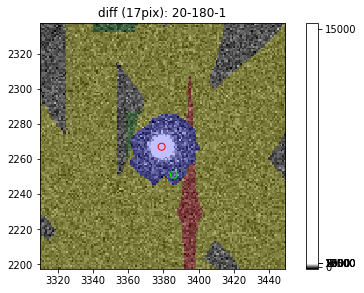

In [356]:
x, y = check20_offset[1]['base_NaiveCentroid_x'], check20_offset[1]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=140, dia_list=dia_20_180[1], title='diff (17pix): 20-180-1')

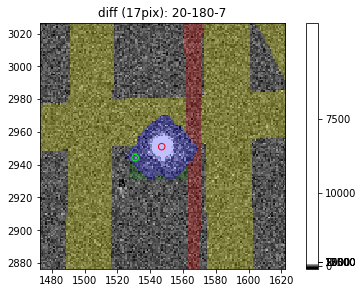

In [186]:
x, y = check20_offset[7]['base_NaiveCentroid_x'], check20_offset[7]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=150, dia_list=dia_20_180[7], title='diff (17pix): 20-180-7')

### 21 175

In [101]:
repo_21_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/al_21_175_offset'
detected_21_175, missed_21_175, dia_21_175 = check_detecion(repo_21_175, calexp_id, 'deepDiff_diaSrc',
                                                            check21_offset, half_side=18, filt_flag=False)

In [102]:
missed_21_175

[]

In [83]:
# [8, 9, 17]

In [81]:
diff_21_175_buter = Butler(repo_21_175)
diff_21_175_exp = diff_21_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_21_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/fake_21_175_offset'
calexp_21_175_buter = Butler(calexp_21_175_repo)

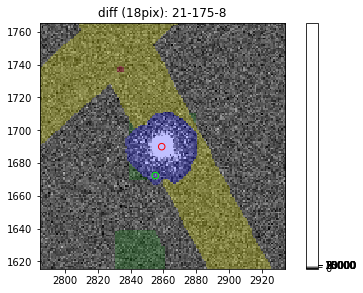

In [184]:
x, y = check21_offset[8]['base_NaiveCentroid_x'], check21_offset[8]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=150, dia_list=dia_21_175[8], title='diff (18pix): 21-175-8')

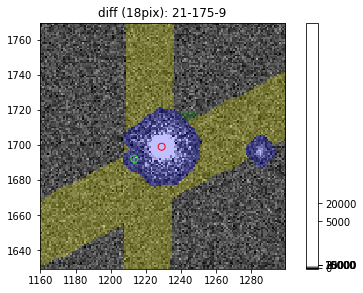

In [183]:
x, y = check21_offset[9]['base_NaiveCentroid_x'], check21_offset[9]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=140, dia_list=dia_21_175[9], title='diff (18pix): 21-175-9')

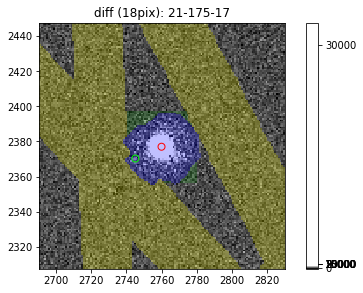

In [188]:
x, y = check21_offset[17]['base_NaiveCentroid_x'], check21_offset[17]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=140, dia_list=dia_21_175[17], title='diff (18pix): 21-175-17')

## 21 180

In [137]:
repo_21_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/al_21_180_offset'
detected_21_180, missed_21_180, dia_21_180 = check_detecion(repo_21_180, calexp_id, 'deepDiff_diaSrc',
                                                            check21_offset, half_side=16, filt_flag=False)

In [138]:
missed_21_180

[]

In [139]:
# 6

In [133]:
diff_21_180_buter = Butler(repo_21_180)
diff_21_180_exp = diff_21_180_buter.get('deepDiff_differenceExp', calexp_id)
calexp_21_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/fake_21_180_offset'
calexp_21_180_buter = Butler(calexp_21_180_repo)

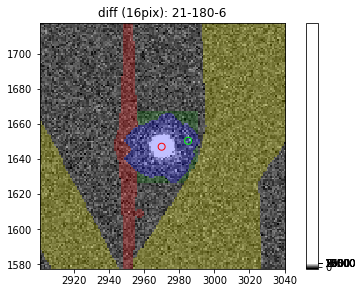

In [181]:
x, y = check21_offset[6]['base_NaiveCentroid_x'], check21_offset[6]['base_NaiveCentroid_y']
display_diff(diff_21_180_exp, x, y, cutout_size=140, dia_list=dia_21_180[6], title='diff (16pix): 21-180-6')

# 22 175, two objects

In [172]:
repo_22_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/al_22_175_offset'
detected_22_175, missed_22_175, dia_22_175 = check_detecion(repo_22_175, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=47, filt_flag=False)



In [173]:
missed_22_175

[]

In [146]:
# 2, 6

In [144]:
diff_22_175_buter = Butler(repo_22_175)
diff_22_175_exp = diff_22_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_22_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/fake_22_175_offset'
calexp_22_175_buter = Butler(calexp_22_175_repo)

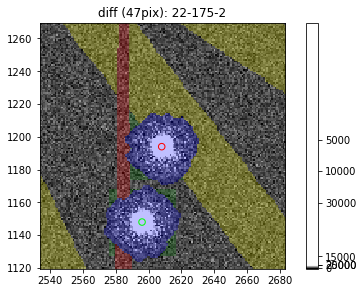

In [175]:
x, y = check22_offset[2]['base_NaiveCentroid_x'], check22_offset[2]['base_NaiveCentroid_y']
display_diff(diff_22_175_exp, x, y, cutout_size=150, dia_list=dia_22_175[2], title='diff (47pix): 22-175-2')

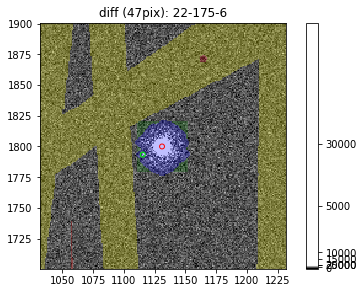

In [177]:
x, y = check22_offset[6]['base_NaiveCentroid_x'], check22_offset[6]['base_NaiveCentroid_y']
display_diff(diff_22_175_exp, x, y, cutout_size=200, dia_list=dia_22_175[6], title='diff (47pix): 22-175-6')

In [360]:

!pwd

/global/u1/s/shl159/fake_injection


### 22 185

In [72]:
repo_22_185  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/al_22_185_offset'
detected_22_185, missed_22_185, dia_22_185 = check_detecion(repo_22_185, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=10, filt_flag=False)


In [73]:
diff_22_185_buter = Butler(repo_22_185)
diff_22_185_exp = diff_22_185_buter.get('deepDiff_differenceExp', calexp_id)
calexp_22_185_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/fake_22_185_offset'
calexp_22_185_buter = Butler(calexp_22_185_repo)

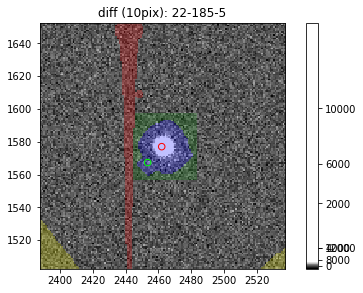

In [179]:
x, y = check22_offset[5]['base_NaiveCentroid_x'], check22_offset[5]['base_NaiveCentroid_y']
display_diff(diff_22_185_exp, x, y, cutout_size=150, dia_list=dia_22_185[5], title='diff (10pix): 22-185-5')

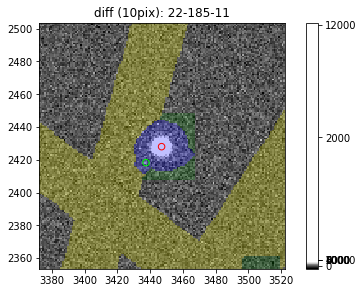

In [190]:
x, y = check22_offset[11]['base_NaiveCentroid_x'], check22_offset[11]['base_NaiveCentroid_y']
display_diff(diff_22_185_exp, x, y, cutout_size=150, dia_list=dia_22_185[11], title='diff (10pix): 22-185-11')

## 23 - 175

In [207]:
repo_23_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/al_23_175_offset'
detected_23_175, missed_23_175, dia_23_175 = check_detecion(repo_23_175, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=16, filt_flag=False)

In [208]:
missed_23_175

[]

In [211]:
# 7

In [214]:
diff_23_175_buter = Butler(repo_23_175)
diff_23_175_exp = diff_23_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_23_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/fake_23_175_offset'
calexp_23_175_buter = Butler(calexp_23_175_repo)

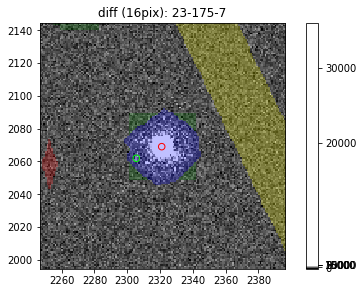

In [216]:
x, y = check23_offset[7]['base_NaiveCentroid_x'], check23_offset[7]['base_NaiveCentroid_y']
display_diff(diff_23_175_exp, x, y, cutout_size=150, dia_list=dia_23_175[7], title='diff (16pix): 23-175-7')

## 23 180

In [232]:
repo_23_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/al_23_180_offset'
detected_23_180, missed_23_180, dia_23_180 = check_detecion(repo_23_180, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=16, filt_flag=False)

In [233]:
missed_23_180

[]

In [231]:
# [0, 14]

In [235]:
diff_23_180_buter = Butler(repo_23_180)
diff_23_180_exp = diff_23_180_buter.get('deepDiff_differenceExp', calexp_id)
calexp_23_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/fake_23_180_offset'
calexp_23_180_buter = Butler(calexp_23_180_repo)

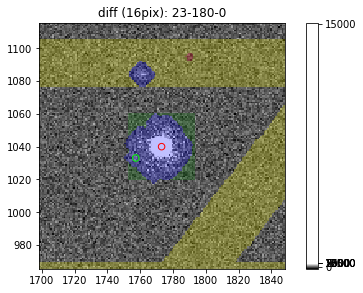

In [236]:
x, y = check23_offset[0]['base_NaiveCentroid_x'], check23_offset[0]['base_NaiveCentroid_y']
display_diff(diff_23_180_exp, x, y, cutout_size=150, dia_list=dia_23_180[0], title='diff (16pix): 23-180-0')

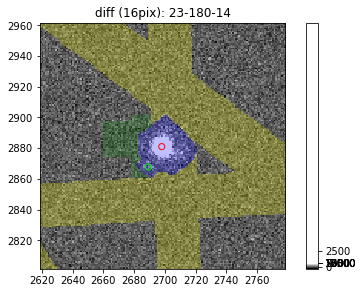

In [238]:
x, y = check23_offset[14]['base_NaiveCentroid_x'], check23_offset[14]['base_NaiveCentroid_y']
display_diff(diff_23_180_exp, x, y, cutout_size=160, dia_list=dia_23_180[14], title='diff (16pix): 23-180-14')

## 24 175

In [256]:
repo_24_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_175_offset'
detected_24_175, missed_24_175, dia_24_175 = check_detecion(repo_24_175, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=16, filt_flag=False)

In [257]:
missed_24_175

[]

In [241]:
# 3

In [258]:
diff_24_175_buter = Butler(repo_24_175)
diff_24_175_exp = diff_24_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_24_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_175_offset'
calexp_24_175_buter = Butler(calexp_24_175_repo)

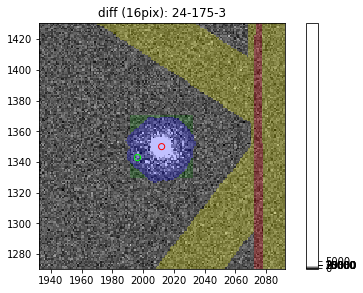

In [260]:
x, y = check24_offset[3]['base_NaiveCentroid_x'], check24_offset[3]['base_NaiveCentroid_y']
display_diff(diff_24_175_exp, x, y, cutout_size=160, dia_list=dia_24_175[3], title='diff (16pix): 24-175-3')

## 24 - 180

In [283]:
repo_24_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_180_offset'
detected_24_180, missed_24_180, dia_24_180 = check_detecion(repo_24_180, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=16, filt_flag=False)

In [284]:
missed_24_180

[]

In [263]:
## [5, 11]

In [280]:
diff_24_180_buter = Butler(repo_24_180)
diff_24_180_exp = diff_24_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_24_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_180_offset'
calexp_24_180_buter = Butler(calexp_24_180_repo)

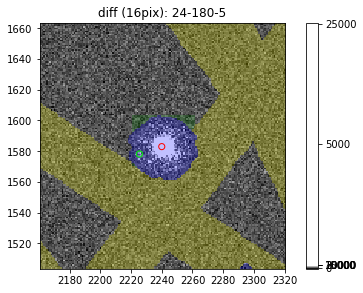

In [281]:
x, y = check24_offset[5]['base_NaiveCentroid_x'], check24_offset[5]['base_NaiveCentroid_y']
display_diff(diff_24_180_exp, x, y, cutout_size=160, dia_list=dia_24_180[5], title='diff (16pix): 24-180-5')

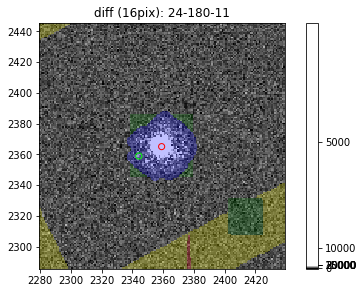

In [282]:
x, y = check24_offset[11]['base_NaiveCentroid_x'], check24_offset[11]['base_NaiveCentroid_y']
display_diff(diff_24_180_exp, x, y, cutout_size=160, dia_list=dia_24_180[11], title='diff (16pix): 24-180-11')

## 24 185

In [305]:
repo_24_185  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_185_offset'
detected_24_185, missed_24_185, dia_24_185 = check_detecion(repo_24_185, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=11, filt_flag=False)

In [306]:
missed_24_185

[]

In [295]:
# 10

In [296]:
diff_24_185_buter = Butler(repo_24_185)
diff_24_185_exp = diff_24_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_24_185_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_185_offset'
calexp_24_185_buter = Butler(calexp_24_185_repo)

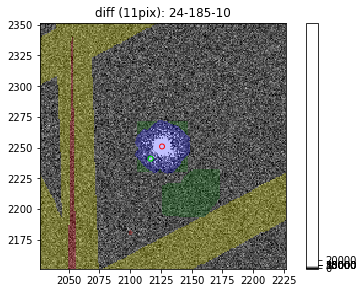

In [308]:
x, y = check24_offset[10]['base_NaiveCentroid_x'], check24_offset[10]['base_NaiveCentroid_y']
display_diff(diff_24_185_exp, x, y, cutout_size=200, dia_list=dia_24_185[10], title='diff (11pix): 24-185-10')

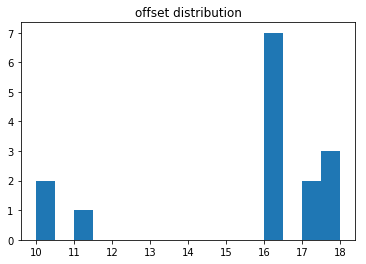

In [358]:
distance = np.array([17, 17, 18, 18, 18, 16, 10, 10, 16, 16, 16, 16, 16, 16, 11])
plt.hist(distance, bins=16)
plt.title('offset distribution')
print()

#### Almost all of these missing objects come from the shifting of the detected position from the injection position. Only one missing source comes from the adjacency to another source（22 175.  Could this shifting issue stems from the bright pixel of the Poisson fluctuation (run injection of the perfect model, check maximum position)?

#### I also need to check the poststamps of the missing objects at the high magnitude tail.

possible configs

doDecorrelation, convolveTemplate (AL, ZOGY)
doSpatiallyVarying, doPreconvolve (just AL?)
